In [5]:
import sys

# IN_COLAB = "google.colab" in sys.modules
# if IN_COLAB and branch == "stable":
#     !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

In [2]:
results_folder = '/nfs/team283_imaging/playground_Tong/C2L_latest/results/lymph_nodes_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [6]:
# Download data if not already here
# import os
# if not os.path.exists('./data/sc.h5ad'):
#     !cd ./data/ && wget https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad

# Read data

adata_ref = sc.read("/nfs/team283_imaging/LY_BRC/playground_Tong/snrna_raw/210603Human.h5ad")
# adata_ref = sc.read(f'./data/sc.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 114047 × 26548
    obs: 'batch', 'bh_pval', 'is_doublet', 'n_counts', 'n_genes', 'percent_mito', 'region', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stage', 'tissue', 'S_score', 'G2M_score', 'phase', 'leiden', 'leiden_R', 'leiden_R_anno', 'leiden_R_anno_id', 'adj_stage', 'adj_sample'
    var: 'n_cells-0-0', 'n_cells-1-0', 'n_cells-10-0', 'n_cells-11-0', 'n_cells-12-0', 'n_cells-13-0', 'n_cells-14-0', 'n_cells-2-0', 'n_cells-3-0', 'n_cells-4-0', 'n_cells-5-0', 'n_cells-6-0', 'n_cells-7-0', 'n_cells-8-0', 'n_cells-9-0', 'n_cells-0-1', 'n_cells-1-1', 'n_cells-2-1', 'n_cells-3-1', 'n_cells-4-1', 'n_cells-5-1', 'n_cells-0-2', 'n_cells-1-2', 'n_cells-2-2', 'n_cells-3-2', 'n_cells-4-2', 'n_cells-5-2', 'n_cells', 'highly_variable'
    uns: 'leiden_R_anno_colors', 'leiden_R_anno_id_colors', 'leiden_R_colors'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap'

In [7]:
# get counts from raw slot
adata_snrna_raw_new = sc.AnnData(adata_ref.X)
adata_snrna_raw_new.obs = adata_ref.obs
adata_snrna_raw_new.var = adata_ref.var
adata_snrna_raw_new.obsm = adata_ref.obsm
adata_snrna_raw_new.uns = adata_ref.uns
adata_snrna_raw_new.obsp = adata_ref.obsp
adata_snrna_raw_new.varm = adata_ref.varm

adata_snrna_raw = adata_snrna_raw_new.copy()

# revert log-transform
adata_snrna_raw.X.data = np.expm1(adata_snrna_raw.X.data)

# revert normalisation
adata_snrna_raw.X = (adata_snrna_raw.X / 10000).multiply(adata_snrna_raw.obs['n_counts'].values.reshape((adata_snrna_raw.n_obs,1)))

# checking that data is integer counts
print(adata_snrna_raw.X.data)

# convert to integer counts
adata_snrna_raw.X.data = np.round(adata_snrna_raw.X.data)

from scipy.sparse import csr_matrix
adata_snrna_raw.X = csr_matrix(adata_snrna_raw.X)
adata_snrna_raw.X.data = adata_snrna_raw.X.data.astype(int)

[ 1.00000008  1.00000008  1.00000008 ...  5.0000009  59.00000586
  1.00000003]


In [19]:
# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched
# adata_ref.var['SYMBOL'] = adata_ref.var.index
# adata_ref.var.index = adata_ref.var['GeneID-2'].copy()
# adata_ref.var_names = adata_ref.var['GeneID-2'].copy()
# adata_ref.var.index.name = None
# adata_ref.raw.var['SYMBOL'] = adata_ref.raw.var.index
# adata_ref.raw.var.index = adata_ref.raw.var['GeneID-2'].copy()
# adata_ref.raw.var.index.name = None

In [8]:
# before we estimate the reference cell type signature we recommend to perform very permissive genes selection
# in this 2D histogram orange rectangle lays over excluded genes.
# In this case, the downloaded dataset was already filtered using this method,
# hence no density under the orange rectangle
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_snrna_raw, cell_count_cutoff=1, cell_percentage_cutoff2=0.01, nonz_mean_cutoff=1.12)

ImportError: cannot import name '_CONSTANTS' from 'scvi' (/opt/conda/lib/python3.8/site-packages/scvi/__init__.py)

In [ ]:
# filter the object
adata_ref = adata_snrna_raw[:, selected].copy()

In [9]:
adata_ref

AnnData object with n_obs × n_vars = 114047 × 26548
    obs: 'batch', 'bh_pval', 'is_doublet', 'n_counts', 'n_genes', 'percent_mito', 'region', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stage', 'tissue', 'S_score', 'G2M_score', 'phase', 'leiden', 'leiden_R', 'leiden_R_anno', 'leiden_R_anno_id', 'adj_stage', 'adj_sample'
    var: 'n_cells-0-0', 'n_cells-1-0', 'n_cells-10-0', 'n_cells-11-0', 'n_cells-12-0', 'n_cells-13-0', 'n_cells-14-0', 'n_cells-2-0', 'n_cells-3-0', 'n_cells-4-0', 'n_cells-5-0', 'n_cells-6-0', 'n_cells-7-0', 'n_cells-8-0', 'n_cells-9-0', 'n_cells-0-1', 'n_cells-1-1', 'n_cells-2-1', 'n_cells-3-1', 'n_cells-4-1', 'n_cells-5-1', 'n_cells-0-2', 'n_cells-1-2', 'n_cells-2-2', 'n_cells-3-2', 'n_cells-4-2', 'n_cells-5-2', 'n_cells', 'highly_variable'
    uns: 'leiden_R_anno_colors', 'leiden_R_anno_id_colors', 'leiden_R_colors'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_umap'

In [2]:
scvi.__version__

'0.16.0'

In [13]:
m = scvi.model.TOTALVI.setup_anndata(adata_ref, "X_draw_graph_fa")

INFO     Generating sequential column names                                                  


/opt/conda/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/scvi/data/fields/_obsm_field.py:102: UserWarning: adata.obsm['X_draw_graph_fa'] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [25]:
# prepare anndata for the regression model
scvi.data.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='adj_sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='leiden_R_anno_id',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['batch']
                       )
scvi.data.view_anndata_setup(adata_ref)

INFO     Using batches from adata.obs["adj_sample"]                                          
INFO     Using labels from adata.obs["leiden_R_anno_id"]                                     
INFO     Using data from adata.X                                                             


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 114047 cells, 14114 vars, 25      
         batches, 55 labels, and 0 proteins. Also registered 1 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.6.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 114047 │
│             Vars             │ 14114  │
│            Labels            │   55   │
│           Batches            │   25   │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   1    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │                adata.X                 │
│ batch_indices │        adata.obs['_scvi_batch']        │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
└───────────────┴────────────────────────────────────────┘

                               Label Categories                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['leiden_R_anno_id'] │      0-ProxMesC       │          0          │
│                               │      1-PAX7+SkMP      │          1          │
│                               │      2-PAX3+SkMP      │          2          │
│                               │        3-LPMC         │          3          │
│                               │      4-POMC+OCP       │          4          │
│                               │      5-ChondroB       │          5          │
│                               │     6-InterMChon      │          6          │
│                               │     7-RestingChon     │          7          │
│                               │    8-PrehyperChon     │          8          │
│                               │      9-InnerPZC       │          9          │
│                               │      10-OuterPZC      │         10          │
│                               │      11-ADH+FiB       │         11          │
│                               │    12-InterMyoFiB     │         12          │
│                               │     13-MFAP5+FiB      │         13          │
│                               │      14-MesConC       │         14          │
│                               │     15-InterZoneC     │         15          │
│                               │     16-STMN2+FiB      │         16          │
│                               │   17-HOXC5+DerFiBP    │         17          │
│                               │       18-TenoP        │         18          │
│                               │     19-ISL1+MesC      │         19          │
│                               │    20-IGSF21+MesC     │         20          │
│                               │     21-PerichonC      │         21          │
│                               │       22-OsteoB       │         22          │
│                               │      23-DermFiB       │         23          │
│                               │    24-F10+DerFiBP     │         24          │
│                               │    25-CITED1+MesC     │         25          │
│                               │ 26-HOPX+AnterProxMesC │         26          │
│                               │    27-PerimysiumC     │         27          │
│                               │       28-TenoC        │         28          │
│                               │        29-SmMP        │         29          │
│                               │     30-NeuralFiB      │         30          │
│                               │     31-Pericytes      │         31          │
│                               │        32-SmMC        │         32          │
│                               │       33-MyoB2        │         33          │
│                               │       34-MyoB1        │         34          │
│                               │       35-MyoC2        │         35          │
│                               │       36-MyoC1        │         36          │
│                               │     37-MYL3+MyoC      │         37          │
│                               │     38-MYH3+MyoC      │         38          │
│                               │      39-SchwannP      │         39          │
│                               │      40-MelanoC       │         40          │
│                               │      41-SchwannC      │         41          │
│                               │     42-VeinEndoC      │         42          │
│                               │   43-ArterialEndoC    │         43          │
│                               │   44-LymphaticEndoC   │         44          │
│                               │   45-PrimitiveRBC1    │         45          │


                               Batch Categories                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃         Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['adj_sample'] │ Pcw5.1_WholeLimb_LowerLimb │          0          │
│                         │ Pcw5.4_s1_Thigh_LowerLimb  │          1          │
│                         │ Pcw5.4_s2_Thigh_LowerLimb  │          2          │
│                         │  Pcw5.6_Distal_LowerLimb   │          3          │
│                         │  Pcw5.6_Distal_UpperLimb   │          4          │
│                         │  Pcw5.6_Middle_LowerLimb   │          5          │
│                         │  Pcw5.6_Middle_UpperLimb   │          6          │
│                         │ Pcw5.6_Proximal_LowerLimb  │          7          │
│                         │ Pcw5.6_Proximal_UpperLimb  │          8          │
│                         │  Pcw6.1_Distal_LowerLimb   │          9          │
│                         │  Pcw6.1_Distal_UpperLimb   │         10          │
│                         │ Pcw6.1_Proximal_LowerLimb  │         11          │
│                         │ Pcw6.1_Proximal_UpperLimb  │         12          │
│                         │ Pcw6.1_s1_Middle_UpperLimb │         13          │
│                         │ Pcw6.1_s2_Middle_UpperLimb │         14          │
│                         │   Pcw6.5_Thigh_LowerLimb   │         15          │
│                         │ Pcw7.2_s1_Thigh_LowerLimb  │         16          │
│                         │ Pcw7.2_s2_Thigh_LowerLimb  │         17          │
│                         │   Pcw8.0_Thigh_LowerLimb   │         18          │
│                         │ Pcw8.4_s1_Thigh_LowerLimb  │         19          │
│                         │ Pcw8.4_s2_Thigh_LowerLimb  │         20          │
│                         │ Pcw9.0_s1_Thigh_LowerLimb  │         21          │
│                         │ Pcw9.0_s2_Thigh_LowerLimb  │         22          │
│                         │ Pcw9.3_s1_Thigh_LowerLimb  │         23          │
│                         │ Pcw9.3_s2_Thigh_LowerLimb  │         24          │
└─────────────────────────┴────────────────────────────┴─────────────────────┘

               Extra Categorical Variables               
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     0      │          0          │
│                    │     1      │          1          │
│                    │     2      │          2          │
│                    │            │                     │
└────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:596: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop


Epoch 17/250:   6%|█▋                         | 16/250 [2:37:17<38:25:02, 591.04s/it, v_num=1, elbo_train=8.76e+8]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...


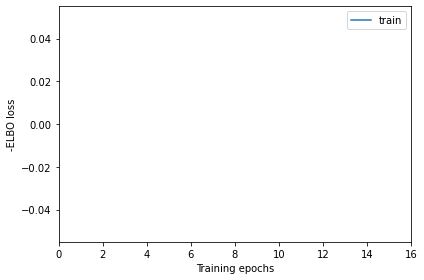

In [26]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=False) 

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [14]:
adata = sc.read_h5ad("/home/jovyan/Documents/cell2location/nextflow/output/210603Human_mapped_cell_types.h5ad")

In [40]:
adata

AnnData object with n_obs × n_vars = 110273 × 88
    obs: 'sample', 'total_counts', 'n_genes_by_counts', '_indices', '_scvi_batch', '_scvi_labels', 0
    var: 'total_counts', 'n_cells_by_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [41]:
adata.uns['mod']

{'date': '2022-04-16',
 'factor_filter': array([], dtype=float64),
 'factor_names': array([0]),
 'model_name': 'Cell2locationBaseModule',
 'obs_names': array(['1', '2', '3', ..., '110271', '110272', '110273'], dtype=object),
 'post_sample_means': {'alpha_g_inverse': array([[ 3.5009139,  3.94507  ,  5.744058 ,  6.630328 ,  5.418825 ,
           6.321382 ,  5.1996055,  6.377139 ,  9.447846 ,  4.388476 ,
           6.361791 , 12.101959 ,  5.116572 ,  5.189422 ,  3.898422 ,
           9.3704   ,  5.570559 ,  4.691522 ,  3.2522476,  1.7555776,
           2.017532 ,  4.177778 ,  1.63205  ,  1.9651892,  3.9301224,
           3.0943902,  2.648915 ,  5.1644573,  2.4281924,  7.451825 ,
           3.189181 ,  5.4353714,  5.9964395,  2.4408169,  3.9747012,
           1.7652081,  6.084187 ,  6.257971 ,  5.6078024,  4.1863213,
           8.35107  ,  3.2731173,  1.2855211,  3.8325684,  5.7352796,
           6.085558 ,  4.513276 ,  4.727968 ,  2.6914263,  2.505294 ,
           2.4974446,  2.8832533,  

In [20]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf']

In [22]:
adata.obs

,sample,total_counts,n_genes_by_counts,_indices,_scvi_batch,_scvi_labels,0
1,,0.0,0,0,0,0,16.014551
2,,0.0,0,1,0,0,16.115256
3,,0.0,0,2,0,0,15.663813
4,,0.0,0,3,0,0,15.878940
5,,0.0,0,4,0,0,16.023795
...,...,...,...,...,...,...,...
110269,,14.0,6,110268,0,0,22.614446
110270,,16.0,7,110269,0,0,24.843158
110271,,18.0,9,110270,0,0,27.202754
110272,,9.0,5,110271,0,0,21.791258


In [23]:
slide = adata

In [36]:
slide.obsm

AxisArrays with keys: means_cell_abundance_w_sf, q05_cell_abundance_w_sf, q95_cell_abundance_w_sf, spatial, stds_cell_abundance_w_sf

In [39]:
slide.obsm["stds_cell_abundance_w_sf"]

,stdscell_abundance_w_sf_0
1,2.050740
2,2.067912
3,2.107793
4,2.085756
5,2.039829
...,...
110269,2.400454
110270,2.317451
110271,2.479540
110272,2.262017


In [45]:
slide

AnnData object with n_obs × n_vars = 110273 × 88
    obs: 'sample', 'total_counts', 'n_genes_by_counts', '_indices', '_scvi_batch', '_scvi_labels', 0
    var: 'total_counts', 'n_cells_by_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [25]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
#                   color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
#                          'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )


ValueError: When .uns['spatial'][library_id] does not exist, spot_size must be provided directly.